Réalisé par : Koussai Ghaouari, Chaima Raach

In [1]:
import cv2
import cv2 as cv  
import numpy as np
import skimage.util
from matplotlib import pyplot as plt
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
import numpy as np 
from skimage import data 
from skimage.util import img_as_ubyte 
from skimage import exposure 
import skimage.morphology as morp 
from skimage.filters import rank 
from skimage.io import imsave, imread
import pandas as pd
import math

In [2]:
path='lena.png'

In [3]:
img = cv.imread('lena.png')
imgGray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

In [4]:
imgGray.shape

(512, 512)

## Effets du bruit gaussien

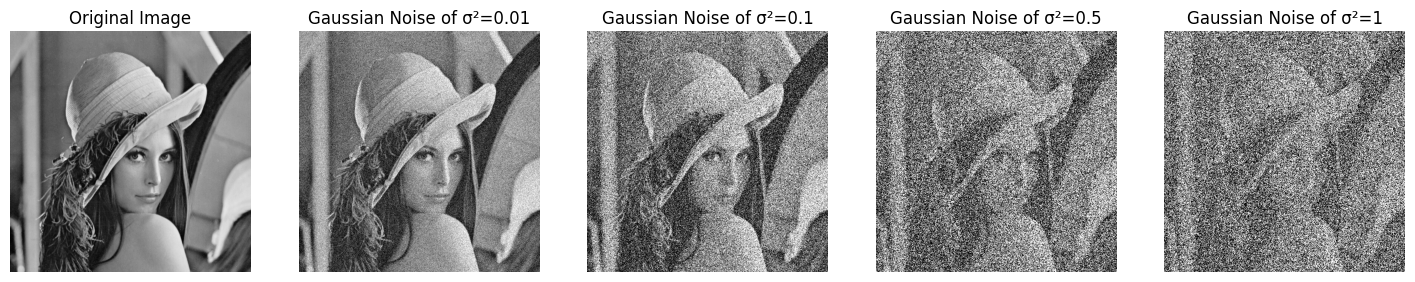

In [5]:
var_values = [0.01, 0.1, 0.5,1]
fig, axes = plt.subplots(1, len(var_values) + 1, figsize=(18, 8))
axes[0].imshow(imgGray, cmap="gray")
axes[0].set_title('Original Image')
axes[0].axis('off')
for i, var in enumerate(var_values):
    imGauss = skimage.util.random_noise(imgGray, mode="gaussian", var=var)
    axes[i+1].imshow(imGauss, cmap="gray")
    axes[i+1].set_title(f'Gaussian Noise of σ²={var}')
    axes[i+1].axis('off')
plt.show()

**Interprétation :** 
-En observant l'imgae réel et l'image dégradé par un bruit gaussien, on remarque que le bruit gaussien Le bruit gaussien a introduit des variations aléatoires de luminosité dans l'image, créant ainsi une texture granuleuse ou rugueuse. ce qui a rendu l'image plus floue ou moins nette, en particulier dans les zones de faible contraste.
-En augmentant la variance du bruit gaussien entraîne une détérioration de l'image : à faible variance (0.1), les détails fins sont obscurcis, tandis qu'à haute variance (1), ils sont complètement perdus, entraînant une perte de clarté et de netteté

## Effets du bruit Sel et poivre

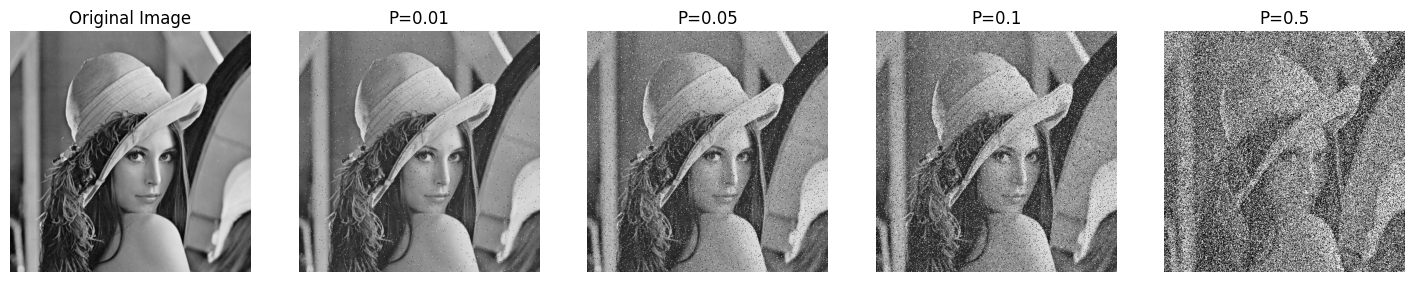

In [6]:
p_values = [0.01,0.05,0.1, 0.5]
fig, axes = plt.subplots(1, len(p_values) + 1, figsize=(18, 8))
axes[0].imshow(imgGray, cmap="gray")
axes[0].set_title('Original Image')
axes[0].axis('off')
for i, p in enumerate(p_values):
    imSP = skimage.util.random_noise(imgGray, mode="s&p", amount=p)
    axes[i+1].imshow(imSP, cmap='gray')  # Use i+1 since the first subplot is occupied by the original image
    axes[i+1].set_title(f'P={p}')
    axes[i+1].axis('off')
plt.show()

**Inteprétation :**
-En observant l'image réelle et l'image dégradée par un bruit sel et poivre, on constate que certains pixels de l'image originale sont altérés de manière aléatoire en noir (sel) ou blanc (poivre), tandis que d'autres pixels demeurent inchangés
-En augmentant le paramètre P du bruit sel et poivre, la densité de pixels altérés augmente, ce qui entraîne une détérioration progressive de la qualité de l'image. Une valeur élevée de P, comme P=0.5, signifie que la moitié des pixels de l'image peuvent être altérés, ce qui rend l'image très bruitée et difficile à analyser, réduisant ainsi sa clarté et sa lisibilité.  

## Comparaison des effets du bruit Gaussien et du bruit Sel & Poivre

In [7]:
imSP = skimage.util.random_noise(imgGray, mode="s&p", amount=0.1)
imGauss = skimage.util.random_noise(imgGray, mode="gaussian", var=0.1)

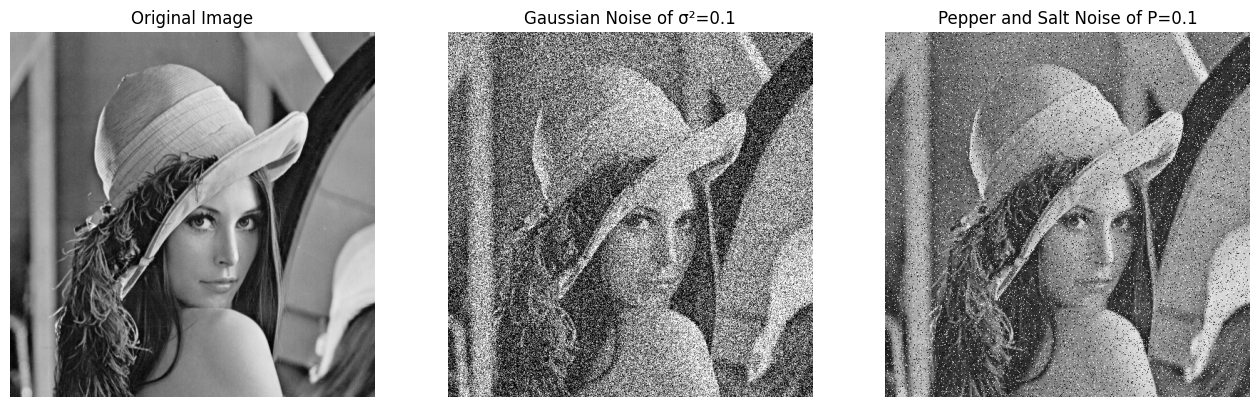

In [8]:
plt.rcParams['figure.figsize'] = [16, 16]
fig, (ax_img, ax_global, ax_local) = plt.subplots(1, 3)
ax_img.imshow(imgGray, cmap=plt.cm.gray)
ax_img.set_title('Original Image')
ax_img.set_axis_off()
ax_global.imshow(imGauss, cmap=plt.cm.gray)
ax_global.set_title(f'Gaussian Noise of σ²={0.1}')
ax_global.set_axis_off()
ax_local.imshow(imSP, cmap=plt.cm.gray)
ax_local.set_title(f'Pepper and Salt Noise of P={0.1}')
ax_local.set_axis_off()
plt.show()

**Interprétation :**
En comparant les deux images dégradées par le bruit sel et poivre et par le bruit gaussien, on observe que le bruit gaussien génère une texture granuleuse et floue qui affecte uniformément l'ensemble de l'image. En revanche, le bruit sel et poivre altère aléatoirement certains pixels de l'image en noir ou blanc, créant des points isolés de distorsion qui compromettent considérablement la clarté et la lisibilité de l'image.

## Filtrage Spatiale 

In [9]:
imGauss=skimage.util.random_noise(img,mode="gaussian",var=0.005)
imSP=skimage.util.random_noise(img,mode="s&p",amount=0.05)

### Filtrage Spatiale du Bruit Guassien

In [10]:
def restore_image(noisy_image, method, kernel_sizes):
    restored_images = []
    for k_size in kernel_sizes:
        if method == 'blur':
            restored = cv2.blur(noisy_image, (k_size, k_size))
        elif method == 'gaussian':
            restored = cv2.GaussianBlur(noisy_image, (k_size, k_size), 0)
        elif method == 'median':
            restored = cv2.medianBlur(noisy_image, k_size)
        else:
            raise ValueError("Invalid method. Supported methods are 'blur', 'gaussian', and 'median'")
        restored_images.append(restored)
    return restored_images

# Parameters

kernel_sizes = [3,5,7]
def test_performance(orig_img, img_noise, method, kernel_sizes):
    img_noise = np.uint8(np.round(img_noise * 255))
    restored_images = restore_image(img_noise, method, kernel_sizes)
    dataset = []
    plt.figure(figsize=(16, 5))
    plt.suptitle(f'Restoration Results using {method} Method', fontsize=16)
    plt.subplot(1, len(kernel_sizes) + 1, 1)
    plt.imshow(img_noise, cmap='gray')
    plt.title("Noisy Image")
    plt.axis('off')
    for i, restored in enumerate(restored_images):
        restored = cv2.cvtColor(restored, cv2.COLOR_RGB2GRAY)
        mse_value = mse(orig_img, restored)
        psnr_value = psnr(orig_img, restored)
        dataset.append({'Kernel Size': kernel_sizes[i], 'MSE': mse_value, 'PSNR': psnr_value})
        plt.subplot(1, len(kernel_sizes) + 1, i + 2)
        plt.imshow(restored, cmap='gray')
        plt.title(f'Kernel Size: {kernel_sizes[i]}\nMSE: {dataset[i]["MSE"]:.2f}\nPSNR: {dataset[i]["PSNR"]:.2f}')
        plt.axis('off')
    plt.show()

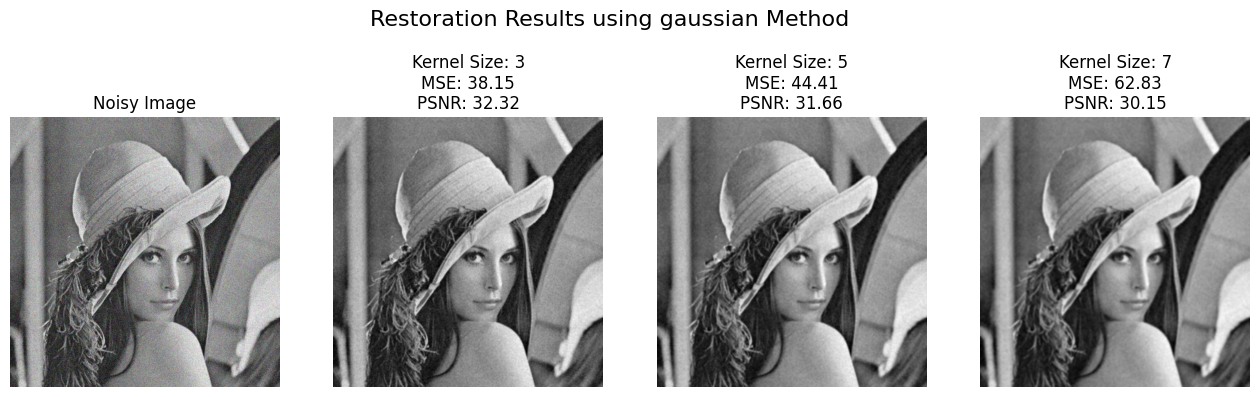

In [11]:
test_performance(imgGray,imGauss,"gaussian",kernel_sizes)

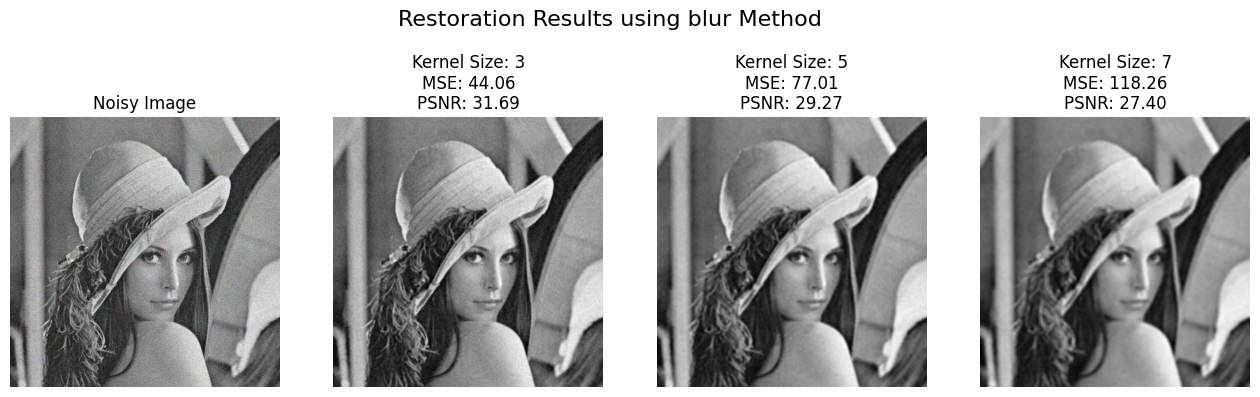

In [12]:
test_performance(imgGray,imGauss,"blur",kernel_sizes)

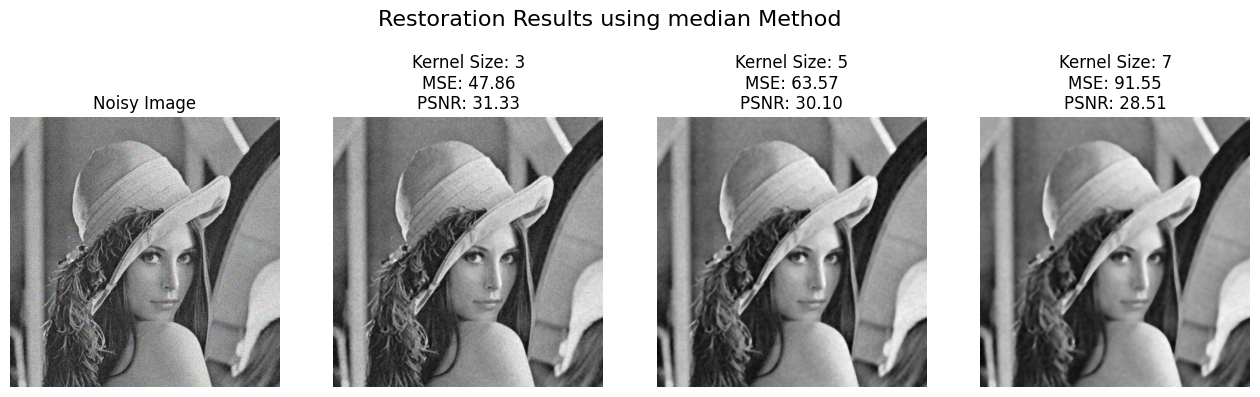

In [13]:
test_performance(imgGray,imGauss,"median",kernel_sizes)

**Interprétation :**
-Lorsqu'on a appliqué un filtre gaussien à une image dégradée par un bruit gaussien, il a été observé que les valeurs optimales de PSNR (Peak Signal-to-Noise Ratio) et de MSE (Mean Squared Error) étaient de 32.36 et de 37.80 respectivement. En fait, le filtre gaussien a réussi à réduire le bruit tout en préservant les détails de l'image mieux que les autres filtres testés.
-En augmentant la taille du noyau des différents filtres, le PSNR et le MSE augmentent également. En outre, On note que cette augmentation est accompagnée d'un effet secondaire : l'image devient plus floue. Ce phénomène est particulièrement remarquable pour le filtre moyenneur, PSNR=27.40, MSE=118.41 pour une taille de noyau=7 .

### Effets de l'écart-type sur la performance du Filtre Gaussien

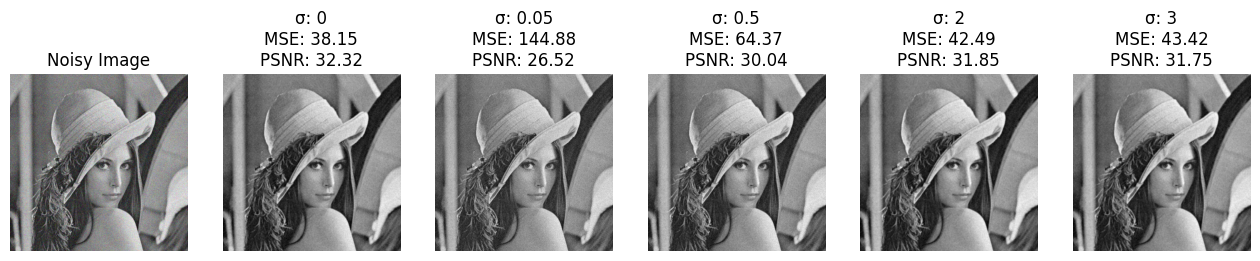

In [14]:
img_noise = np.uint8(np.round(imGauss * 255))
orig_img=imgGray.copy()
variances=[0,0.05,0.5,2,3]
kernel_size=3
restored_images=[]
for var in variances:
    restored = cv2.GaussianBlur(img_noise, (kernel_size, kernel_size), var,var)
    restored=cv.cvtColor(restored,cv.COLOR_RGB2GRAY)
    restored_images.append(restored)
dataset = []
plt.figure(figsize=(16, 5))
plt.subplot(1, len(variances) + 1, 1)
plt.imshow(img_noise, cmap='gray')
plt.title("Noisy Image")
plt.axis('off')
for i, restored in enumerate(restored_images):
    mse_value = mse(orig_img, restored)
    psnr_value = psnr(orig_img, restored)
    dataset.append({'variances':variances[i], 'MSE': mse_value, 'PSNR': psnr_value})
    plt.subplot(1, len(variances) + 1, i + 2)
    plt.imshow(restored, cmap='gray')
    plt.title(f'σ: {variances[i]}\nMSE: {dataset[i]["MSE"]:.2f}\nPSNR: {dataset[i]["PSNR"]:.2f}')
    plt.axis('off')
plt.show()

In [15]:
variances=np.linspace(0,5,100)
kernel_size=3
restored_images=[]
for var in variances:
    restored = cv2.GaussianBlur(img_noise, (kernel_size, kernel_size), var,var)
    restored=cv.cvtColor(restored,cv.COLOR_RGB2GRAY)
    restored_images.append(restored)
dataset = []
for i, restored in enumerate(restored_images):
    mse_value = mse(orig_img, restored)
    psnr_value = psnr(orig_img, restored)
    dataset.append({'variances':variances[i], 'MSE': mse_value, 'PSNR': psnr_value})
dataset=pd.DataFrame(dataset)

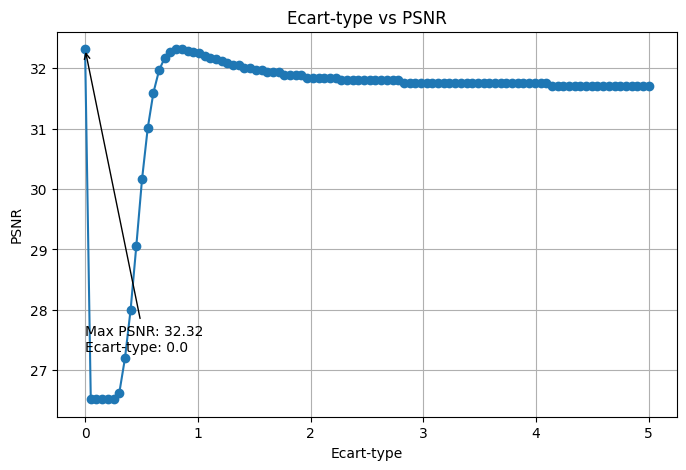

Le maximum de PSNR est: 32.31610163876029
Il est atteint pour l' ecart-type: 0.0


In [16]:
plt.figure(figsize=(8, 5))
plt.plot(dataset['variances'], dataset['PSNR'], marker='o', linestyle='-')
plt.title('Ecart-type vs PSNR')
plt.xlabel('Ecart-type')
plt.ylabel('PSNR')
plt.grid(True)
max_psnr = np.max(dataset['PSNR'])
max_index = np.argmax(dataset['PSNR'])
max_variance = dataset['variances'][max_index]
plt.annotate(f'Max PSNR: {max_psnr:.2f}\nEcart-type: {max_variance}',
             xy=(max_variance, max_psnr),
             xytext=(max_variance, max_psnr - 5),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='left')
plt.show()
print("Le maximum de PSNR est:", max_psnr)
print("Il est atteint pour l' ecart-type:", max_variance)

In [17]:
dataset

variances         MSE       PSNR
0    0.000000   38.147861  32.316102
1    0.050505  144.883999  26.520599
2    0.101010  144.883999  26.520599
3    0.151515  144.883999  26.520599
4    0.202020  144.883999  26.520599
..        ...         ...        ...
95   4.797980   43.888874  31.707259
96   4.848485   43.888874  31.707259
97   4.898990   43.888874  31.707259
98   4.949495   43.888874  31.707259
99   5.000000   43.888874  31.707259

[100 rows x 3 columns]

**Interprétation :**
Lorsque l'écart-type du filtre gaussien est égal à zéro, le PSNR est égal à 32.35. À mesure que l'écart-type augmente jusqu'à environ 0.35, le PSNR diminue, atteignant un minimum d'environ 26.5. En augmentant légèrement l'écart-type jusqu'à environ 0.8, le PSNR augmente à nouveau jusqu'à 32.35. Cela suggère que le lissage appliqué par le filtre gaussien est moins sévère à cet écart-type, permettant à l'image de récupérer une partie de sa netteté et de sa qualité initiales. Cependant, à des valeurs d'écart-type supérieures à 0.8, le PSNR commence à diminuer, jusqu'à atteindre 31.7 où il reste inchangé.

### Filtrage Spatiale du bruit Sel et Poivre

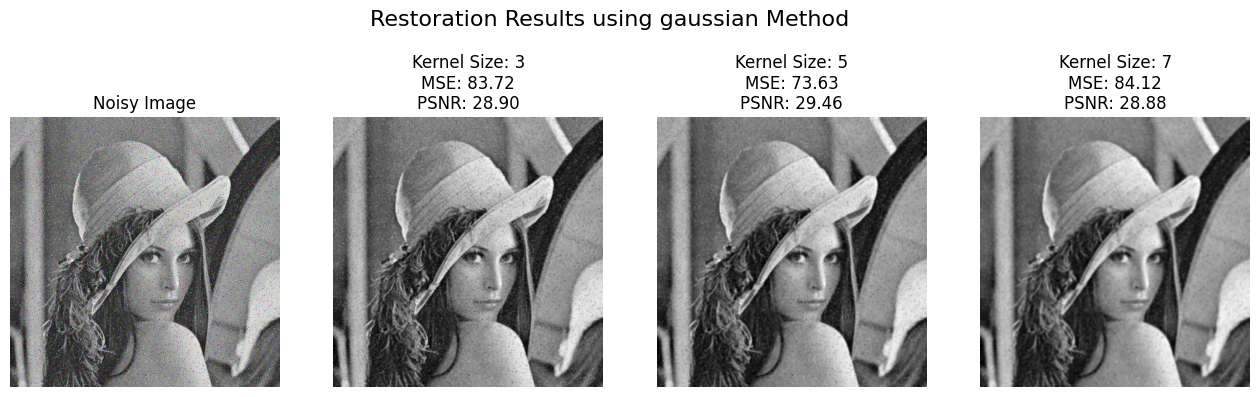

In [18]:
test_performance(imgGray,imSP,"gaussian",kernel_sizes)

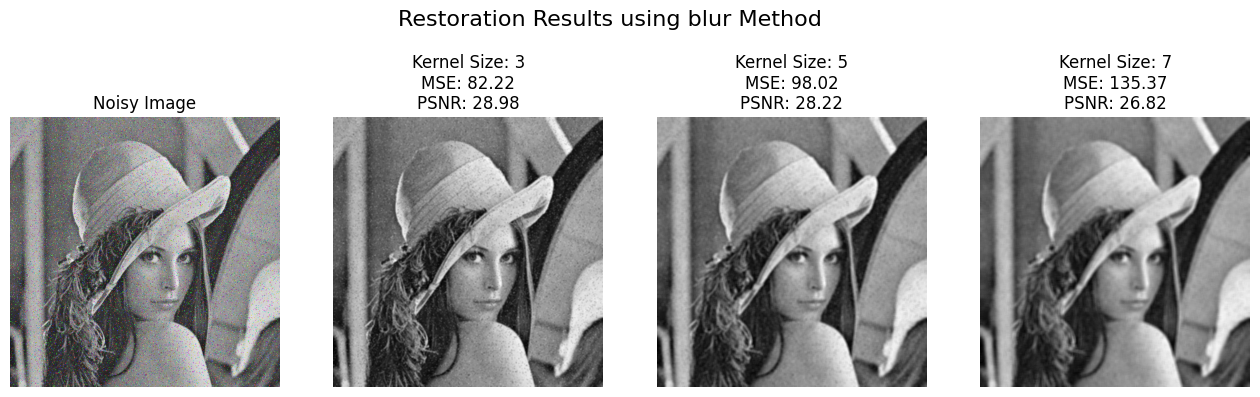

In [19]:
test_performance(imgGray,imSP,"blur",kernel_sizes)

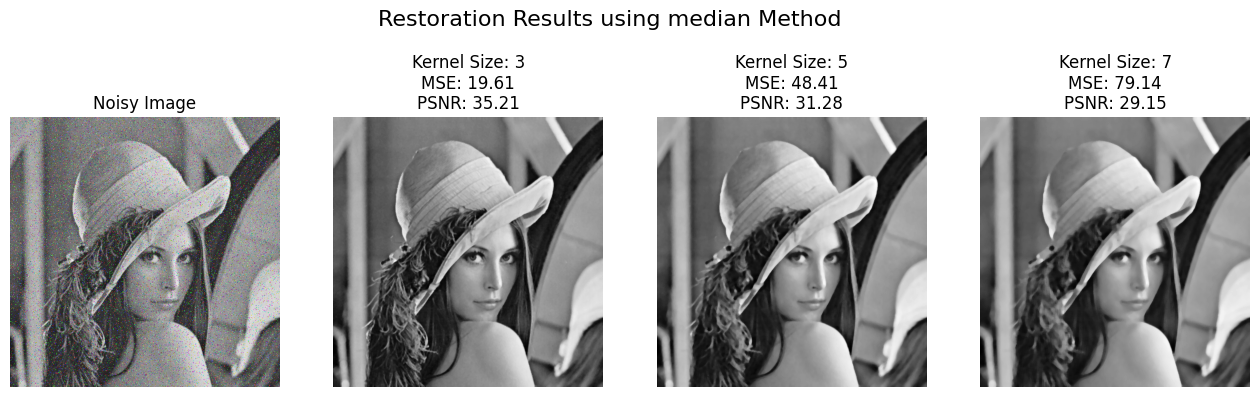

In [20]:
test_performance(imgGray,imSP,"median",kernel_sizes)

**Interprétation :**
-Le filtre médian a enregistré le PSNR le plus élevé, à 35.19, et le MSE le plus bas, à 19.68, par rapport aux autres filtres. En effet, le filtre médian est un filtre non linéaire capable de réduire efficacement les bruits de type sel et poivre.
-En augmentant la taille du noyau des différents filtres, on remarque que le PSNR diminue et le MSE augmente, illustrant l'effet de flou. Pour le filtre gaussien et le filtre médian, cet effet de flou est atténué, ce qui se traduit par une légère altération de leur performance. En revanche, pour le filtre moyenneur, on observe une diminution significative du PSNR jusqu'à 26,83 et une augmentation notable du MSE, mettant en évidence son effet de lissage excessif. 


## NL-MEANS

In [21]:
from numba import njit,prange
from skimage import data, img_as_float
from tqdm import tqdm
def nl_means(
    
                      image, kernel_r=7, kernel_t=11, h=0.1,sigma=0.

):
    r=kernel_r
    t=(kernel_t-1)//2
    h=h
    var=sigma * sigma
    if r % 2 == 0:
        r+= 1  

    dtype = np.float32 if image.dtype == np.float32 else np.float64

    n_row, n_col = image.shape
    offset = r// 2
    padded = np.pad(image, ((offset, offset), (offset, offset)), mode='reflect')
    result = np.empty_like(image)
    A = (r - 1.) / 4.
    range_vals = np.arange(-offset, offset + 1, dtype=dtype)
    xg_row, xg_col = np.meshgrid(range_vals, range_vals, indexing='ij')
    w = np.exp(-(xg_row * xg_row + xg_col * xg_col) / (2 * A * A))
    w *= 1. / (np.sum(w) * h * h)
    var *= 2
    total_samples=n_row*n_col
    progress_bar = tqdm(total=total_samples, desc=f"Preprocessing", unit="pixels")
    for row in range(n_row):
        i_start = row - min(t, row)
        i_end = row + min(t + 1, n_row - row)

        for col in range(n_col):
            new_value=0
            weight_sum = 0
            central_patch = padded[row:row+r, col:col+r]
            j_start = col - min(t, col)
            j_end = col + min(t + 1, n_col - col)

            for i in range(i_start, i_end):
                for j in range(j_start, j_end):
                    weight = patch_distance(central_patch, padded[i:i+r, j:j+r], w, r, var)
                    weight_sum += weight
                    new_value += weight * padded[i+offset, j+offset]
            result[row, col] = new_value / weight_sum
            progress_bar.update(1)
    progress_bar.close()

    return np.squeeze(result)
@njit()
def patch_distance(p1, p2, w, r, var):
    distance = 0
    for i in range(r):
        if distance>5.0:
            return 0
        for j in range(r):
                tmp_diff = p1[i, j] - p2[i, j,]
                distance += w[i, j] * (tmp_diff * tmp_diff )
    return np.exp(-max(0.0, distance-2*var))

### Influence de la taille de la région de recherche et de la taille du patch sur la performance de Nlmeans

In [22]:
sigma=0.08
imGauss=skimage.util.random_noise(imgGray,mode="gaussian",var=sigma**2)

Preprocessing: 100%|██████████| 262144/262144 [05:02<00:00, 867.35pixels/s] 


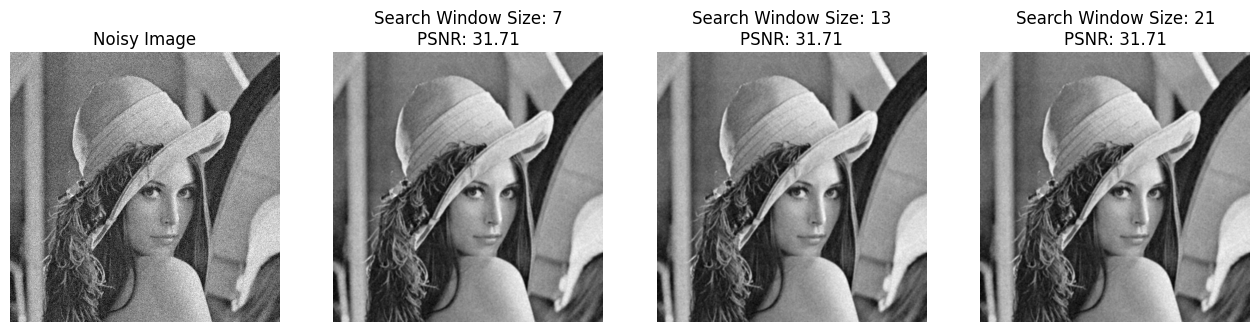

In [23]:
kernel_t = [7,13,21]
kernel_r=5
restored_images = []
for k_t in kernel_t:
    resotred=nl_means(imGauss,kernel_r=kernel_r,kernel_t=k_t,sigma=sigma,h=1.15*sigma)
    restored_images.append(restored)
dataset = []
plt.figure(figsize=(16, 5))
plt.subplot(1, len(kernel_t) + 1, 1)
plt.imshow(imGauss, cmap='gray')
plt.title("Noisy Image")
plt.axis('off')
for i, restored in enumerate(restored_images):
    psnr_value = psnr(imgGray, restored)
    dataset.append({'Search Window Size': kernel_t[i], 'PSNR': psnr_value})
    plt.subplot(1, len(kernel_t) + 1, i + 2)
    plt.imshow(restored, cmap='gray')
    plt.title(f'Search Window Size: {kernel_t[i]}\nPSNR: {dataset[i]["PSNR"]:.2f}')
    plt.axis('off')
plt.show()

Preprocessing: 100%|██████████| 262144/262144 [00:30<00:00, 8631.92pixels/s]


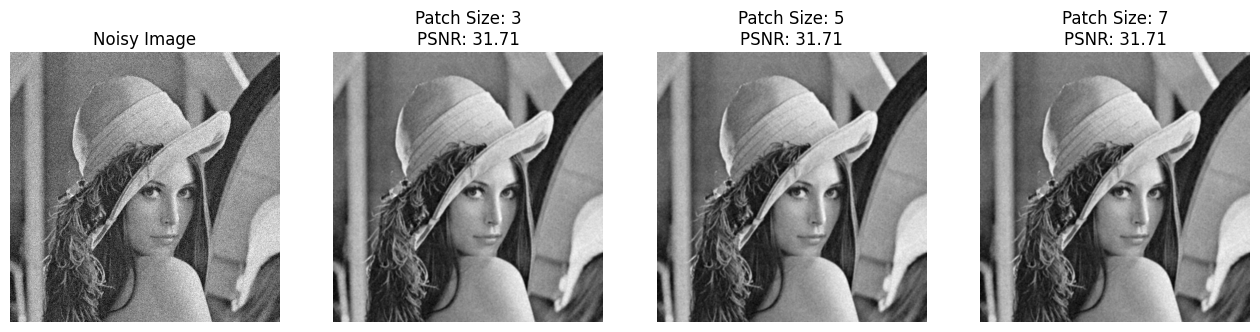

In [24]:
kernel_r = [3,5,7]
kernel_t=7
restored_images = []
for k_r in kernel_r:
    resotred=nl_means(imGauss,kernel_r=k_r,kernel_t=kernel_t,sigma=sigma,h=1.15*sigma)
    restored_images.append(restored)
dataset = []
plt.figure(figsize=(16, 5))
plt.subplot(1, len(kernel_r) + 1, 1)
plt.imshow(imGauss, cmap='gray')
plt.title("Noisy Image")
plt.axis('off')
for i, restored in enumerate(restored_images):
    psnr_value = psnr(imgGray, restored)
    dataset.append({'Patch Size': kernel_r[i], 'PSNR': psnr_value})
    plt.subplot(1, len(kernel_r) + 1, i + 2)
    plt.imshow(restored, cmap='gray')
    plt.title(f'Patch Size: {kernel_r[i]}\nPSNR: {dataset[i]["PSNR"]:.2f}')
    plt.axis('off')
plt.show()

**Interprétation :**
Pour cette image spécifique (Lena.png) bruitée par un bruit gaussien de variance 0.0064, les variations de la taille de la région de recherche ou de la taille du patch n'ont pas eu d'impact significatif sur la performance de Nlmean en termes de PSNR (31.71). Une configuration avec kernel_t=7 (taille de la région de recherche) et kernel_r=5 (taille du patch) soit déjà efficace pour Nlmeans.

### Évaluation comparative des performances de débruitage entre les filtres médian, gaussien et NLmeans sur des images affectées par un bruit gaussien

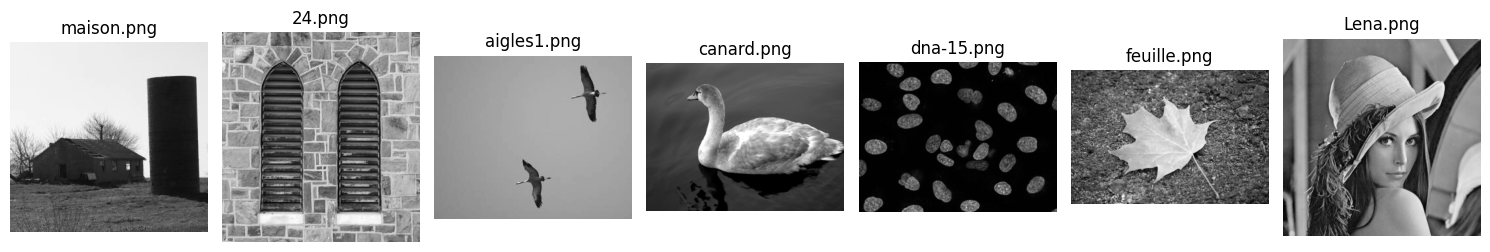

In [33]:
paths=["maison.png","24.png","aigles1.png","canard.png","dna-15.png","feuille.png","Lena.png"]
fig = plt.figure(figsize=(15, 5))
for i, path in enumerate(paths, start=1):
    img = cv2.imread(path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ax = fig.add_subplot(1, len(paths), i)
    ax.imshow(gray_img, cmap='gray')
    plt.axis('off')
    ax.set_title(path)
plt.tight_layout()
plt.show()

Preprocessing: 100%|██████████| 262144/262144 [05:15<00:00, 831.26pixels/s] 


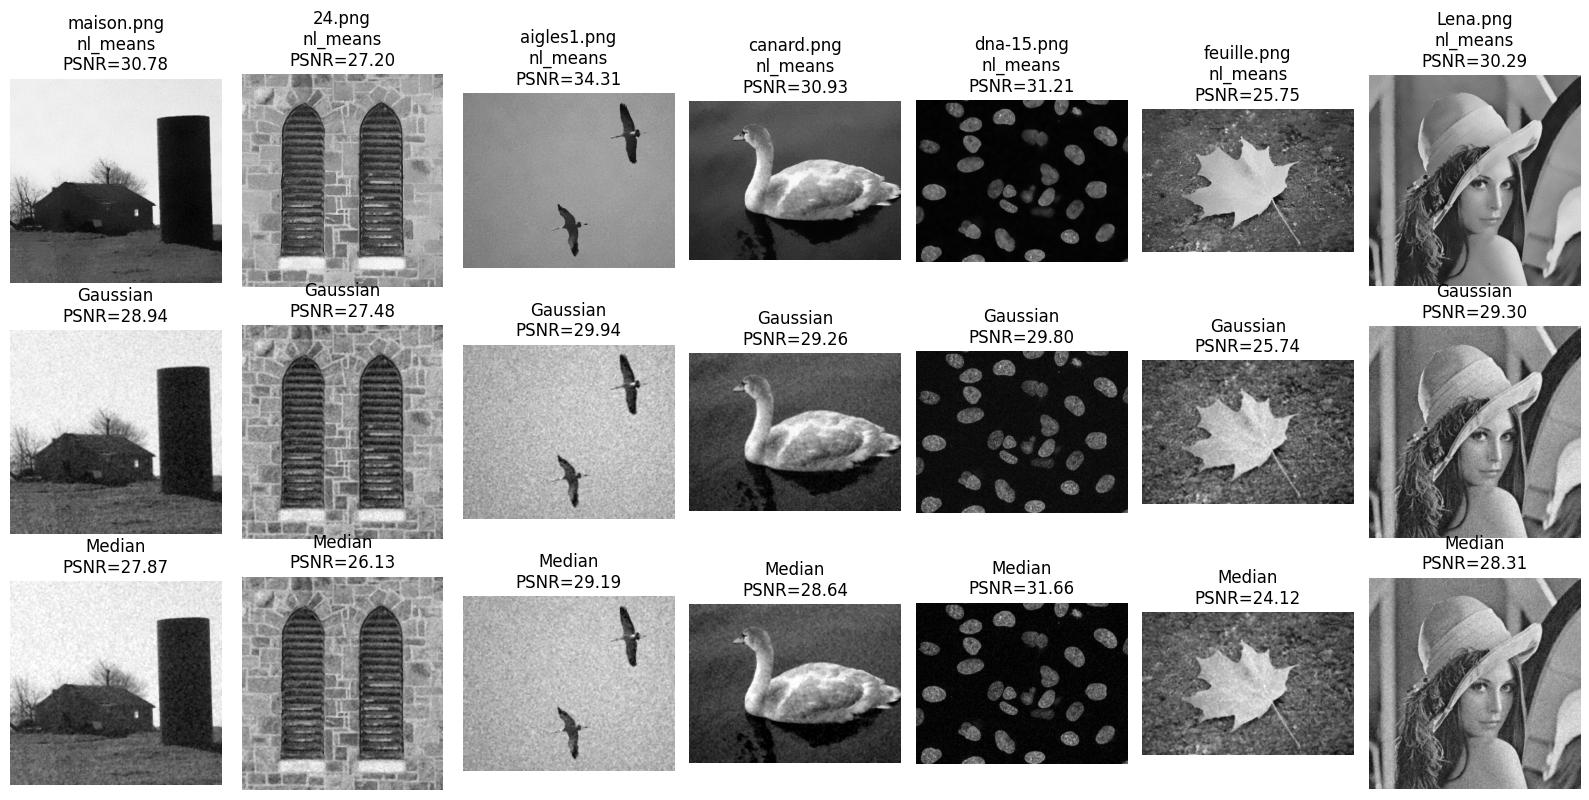

In [35]:
num_images = len(paths)
plt.figure(figsize=(16, 8))

for i, path in enumerate(paths, 1):
    sigma = 0.08
    img = cv.imread(path)
    imgGray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    imGauss = skimage.util.random_noise(imgGray, mode="gaussian", var=sigma ** 2)
    restored_nl =nl_means(imGauss,kernel_r=5,kernel_t=21,sigma=sigma,h=1.15*sigma)
    restored_gauss = cv.GaussianBlur(imGauss, (3, 3), 0)
    restored_median = cv.medianBlur(np.uint8(imGauss * 255), 3)
    psnr_nl = psnr(imgGray, np.uint8(restored_nl * 255))
    psnr_gauss = psnr(imgGray, np.uint8(restored_gauss * 255))
    psnr_median = psnr(imgGray, restored_median)

    # Create a new subplot
    plt.subplot(3, num_images, i)
    plt.imshow(np.uint8(restored_nl * 255), cmap='gray')
    plt.title(f'{path}\nnl_means\nPSNR={psnr_nl:.2f}')
    plt.axis('off')

    # Create a new subplot
    plt.subplot(3, num_images, num_images + i)
    plt.imshow(restored_gauss, cmap='gray')
    plt.title(f'Gaussian\nPSNR={psnr_gauss:.2f}')
    plt.axis('off')

    # Create a new subplot
    plt.subplot(3, num_images, 2 * num_images + i)
    plt.imshow(restored_median, cmap='gray')
    plt.title(f'Median\nPSNR={psnr_median:.2f}')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Interprétation :**
L'algorithme NLMeans a démontré une performance remarquable en termes de PSNR, surpassant le filtre gaussien et le filtre médian sur l'ensemble des images bruitées par un bruit gaussien, à l'exception de l'image 24.png et l'image DNA-15.png. Dans le cas de l'image 24.png, NLMeans a produit un PSNR de 27.20, ce qui est très proche du PSNR du filtre gaussien à 27.48. Pour l'image DNA-15, NLMeans a affiché un PSNR de 31.21, tandis que le filtre median avait un PSNR légèrement supérieur à 31.66. Ce qui est notable, c'est que NLMeans a réussi à préserver les détails des images de manière plus efficace que le filtre médian et le filtre gaussien.